# Procedure for an indirect test of the time-drift effect:
1. Use Sloan Digital Sky Survey (SDSS) SQL Queries to select galaxies within a redshift (z) range 0.15 < z < 0.3. This range is chosen from Morseco (2011), *"Early-type galaxies as probes of galaxy formation and cosmology,"* for its S/N strength using the $D4000_n$ parameter.

2. Collect and label spectrum and feature data for each galaxy. Spectrum data can then be used to:

    * Make data quality cuts based on error values.

    * Characterize galaxy class.

    * Determine if the galaxy has an active galactic nuclei (AGN).

3. Determine the galaxy's morphology. This is used as a control variable to prevent mixing data from populations that evolve differently regardless of environment.

4. Determine the galaxy's local population density within a range of volumes.

5. Create different plots of data with population density as the independent variable (x-axis) and $D4000_n$ and $H\delta$ as the dependent variables. Split plots by environment (local population density: void/underdense, filament/field, wall/cluster) for different morphologies and SFHs.
6. Investigate **systematic offsets/divergences** between environment classes.

# 1. SQL Query
This step is handled using two separate queries and results in two final CSV files with different data. The Galaxy Zoo project only has morphology estimates for 27109 galaxies in the given redshift range, while the total SDSS sample for the same range includes 324048 galaxies. To avoid timeout errors in either sample, two functions were created using the arguments of a chunk size (number of galaxies to select), the objid of the last object in the previous list (0 can be chosen for the initial value), and a general filename to query SDSS before creating a CSV file of the given chunk size number of galaxies. The two functions differ only in their query text. The generated files are named iteratively using the filename argument and the final objid in the generated table. This objid is also returned as a value to be used in a looping function. 

A second function then loops this function using the final objid until there are no galaxies left. After exhausting the pool of galaxies, this function then combines all the previous CSV files into a single larger one to simplify future function calls.

The exact RA, DEC, z, zerr, plate, mjd, and fiberid can all be collected from the FITS file, as well as the spectral data required for analysis.

This query can then return a CSV file which has as one of its columns a link to a downloadable FITS file. These files can then be downloaded and put into another file as:

In [ ]:
import pandas as pd
import requests
from pathlib import Path
from astroquery.sdss import SDSS

def sdss_chunk_query(chunk_size, last_id, file_name, folder_name):
    """
    SQL search SDSS database to return a csv file with the objid, plate, mjd, fiberid,
    and FITS file URL for all galaxies between z=0.13 to z=0.3, 50000 galaxies at a time
    to prevent timeout.
    """
    # 
    sdss_chunk = f"""
SELECT TOP {chunk_size}
p.objid, s.plate, s.mjd, s.fiberid,
dbo.fGetUrlFitsSpectrum(s.specObjID) AS spec_fits_url
FROM PhotoObj AS p
JOIN SpecObj AS s
    ON p.objid = s.bestobjid
JOIN Galaxy AS g
    ON g.objid = p.objid
    WHERE s.class = 'GALAXY'
    AND s.z BETWEEN 0.15 AND 0.3
    AND s.zWarning = 0
    AND p.objid > {last_id}
ORDER BY p.objid
    """
    table = SDSS.query_sql(sdss_chunk)
    if table is None:
        return None, None
    last_id = table[-1][0]
    new_file_name = f'{file_name}{last_id}.csv'
    table.write(f"{folder_name}/{new_file_name}", format="csv", overwrite=True)
    return last_id, new_file_name

def galaxy_zoo_chunk_query(chunk_size, last_id, file_name, folder_name):
    """
    SQL search SDSS database to return a csv file with the confidence rating for
    if a galaxy is elliptical, clockwise spiral, anticlockwise spiral, edgeon,
    unknown, or merger for every shared SDSS & Galaxy Zoo object between z=0.15 to z=0.3
    """
    galaxy_zoo_chunk = f"""
SELECT TOP {chunk_size}
p.objid,
zns.p_el as elliptical,
zns.p_cw as spiralclock,
zns.p_acw as spiralanticlock,
zns.p_edge as edgeon,
zns.p_dk as dontknow,
zns.p_mg as merger
FROM PhotoObj AS p
JOIN SpecObj AS s
    ON p.objid = s.bestobjid
JOIN Galaxy AS g
    ON g.objid = p.objid
JOIN ZooNoSpec AS zns
    ON zns.objid = g.objid
WHERE 
    s.class = 'GALAXY'
    AND s.z BETWEEN 0.15 AND 0.3
    AND s.zWarning = 0
    AND p.objid > {last_id}
ORDER BY p.objid
    """
    table = SDSS.query_sql(galaxy_zoo_chunk)
    if table is None:
        return None, None
    last_id = table[-1][0]
    new_file_name = f'{file_name}{last_id}.csv'
    table.write(f"{folder_name}/{new_file_name}", format="csv", overwrite=True)
    return last_id, new_file_name

def merge_csv(files, final_file, final_folder):
    """
    Take a list of CSV files and combine them into a single file.
    """
    outdir = Path(final_folder)
    outdir.mkdir(exist_ok=True)
    df_list = [pd.read_csv(f) for f in files]
    combined = pd.concat(df_list, ignore_index=True)
    combined.to_csv(f"{outdir}/{final_file}", index=False)
    return combined

def cleanup_files(files):
    """
    Deletes a list files, helping to conserve memory.
    """
    for f in files:
        Path(f).unlink(missing_ok=True)


def loop_galaxy_chunk(query, chunk_size, last_id, file_name, final_file, folder_name):
    """
    Loop the SQL search until exhausted, at which point concatenate all generated CSV files into a new one.
    """
    csv_file_list = []
    outdir = Path(folder_name)
    outdir.mkdir(exist_ok=True)
    while True:
        try:
            print(f'Collecting next {chunk_size} galaxies...')
            last_id, new_file_name = query(chunk_size, last_id, file_name, folder_name)
            if last_id is None:
                break
            else:
                new_file_name = f"{outdir}\{new_file_name}"
                csv_file_list.append(new_file_name)
                print("Success!")
        except Exception as e:
            print(f'Error: query failed at {last_id}\n{e}')
            raise
    print(f'Finished collecting galaxies. Merging {len(csv_file_list)} CSV files...')
    merge_csv(csv_file_list, final_file, folder_name)
    print("Deleting builder files...")
    cleanup_files(csv_file_list)
    print("Done!")

loop_galaxy_chunk(galaxy_zoo_chunk_query, 10000, 0, "galaxy_zoo_morphology_", "full_morphology.csv", "ZOO")
loop_galaxy_chunk(sdss_chunk_query, 10000, 0, "sdss_db_", "full_sdss.csv", "SDSS")

def download_fits_chunk(df, start, end, outdir="FITS"):
    """
    Uses final SDSS CSV file to fill a FITS folder with the 
    downloaded FITS files of all available galaxies.
    """
    outdir = Path('FITS')
    outdir.mkdir(exist_ok=True)

    for i in range(start, end):
        row = df.iloc[i]
        
        plate = row["plate"]
        mjd   = row["mjd"]
        fiber = row["fiberid"]
        url   = f""

        filename = f'spec-{plate}-{mjd}-{fiber:04d}.fits'
        filepath = outdir / filename

        if filepath.exists():
            continue

        r = requests.get(url, stream=True)
        r.raise_for_status()

        with open(filepath, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)


# Load the test CSV
#df = pd.read_csv('Skyserver_SQL12_22_2025 10_54_56 PM.csv', comment='#')
#download_data(df)

Extracting from the returned FITS file (spec_fits_url) and converting to rest wavelength using $\lambda_{rest} = \frac{\lambda_{obs}}{(1 + z)}$:

1. Break strength at 4000 $\AA$. Flux from 4000-4100 $\AA$, $F_{red}$ and 3850-3950 $\AA$, $F_{blue}$. $$D4000_n = \frac{F_{red}}{F_{blue}}$$ This value must be calculated from the data.

2. The uncertainty in $D4000_n$, found using the inverse variance of the same flux ranges as $$\sigma(D4000_n)=D4000_n \times \sqrt{(\frac{\sigma F_{red}}{F_{red}})^2 + (\frac{\sigma F_{blue}}{F_{blue}})^2}$$ This value must be calculated from the data.

3. The flux produced by singly-ionized oxygen at a wavelength of 3727 $\AA$, denoted $[O \text{ } _{II}]\lambda3727$.

4. The rest frame equivalent width of this line ($W_0[O \text{ } _{II}]$).

5. The flux of the $H\delta$ Balmer line at 4101 $\AA$.

6. The rest frame equivalent width of this line ($W_0[H\delta]$).

# 2. Collect and label spectrum data for each galaxy
The collect_spectrum_data function is designed to extract the above data from a single FITS file, returning a dictionary of the related values.

In [ ]:
from astropy.io import fits
import numpy as np
# Extract data

def collect_spectrum_data(file):
    """
    Compute D4000n, collect [OII] 3727 & Hdelta flux/EW from a single SDSS FITS spectrum file.

    Negative Err values = invalid fit.

    Flux is negative for absorption spectra, positive for emission.
    """
    # Open file
    hdul = fits.open(file)
    
    # Assign dfs
    hdu     = hdul[0].header
    coadd   = hdul[1].data
    specobj = hdul[2].data
    spzline = hdul[3].data

    # Info
    ra  = hdu['PLUG_RA']
    dec = hdu['PLUG_DEC']

    # Label data
    plate = spzline['PLATE'][0]
    mjd   = spzline['MJD'][0]
    fiber = spzline['FIBERID'][0]
    objid = specobj['bestObjID'][0]
    fileid = f'spec-{plate}-{mjd}-{fiber:04d}'

    # Flux and wavelength
    flux       = coadd['flux']
    loglam     = coadd['loglam']
    lambda_obs = 10**loglam
    ivar       = coadd['ivar']

    # Redshift
    z     = specobj['Z'][0]
    z_err = specobj['Z_ERR'][0]

    # Shift to rest-frame
    lambda_rest = lambda_obs / (1 + z)

    # Find D4000n and uncertainty
    red_mask     = (lambda_rest >= 4000) & (lambda_rest <= 4100)
    blue_mask    = (lambda_rest >= 3850) & (lambda_rest <= 3950)
   
    F_red        = np.mean(flux[red_mask])
    red_ivar     = ivar[red_mask]

    F_blue       = np.mean(flux[blue_mask])
    blue_ivar    = ivar[blue_mask]

    D4000n       = F_red / F_blue

    # Protect against divisions by zero
    good_red = red_ivar > 0
    good_blue = blue_ivar > 0
    if good_red.sum() == 0 or good_blue.sum() == 0:
        sigma_D4000n = np.inf
    else:    
        sigma_red    = np.sqrt(1 / np.sum(red_ivar[good_red]))
        sigma_blue   = np.sqrt(1 / np.sum(blue_ivar[good_blue]))
        sigma_D4000n = D4000n * np.sqrt(
        (sigma_red / F_red)**2 +
        (sigma_blue / F_blue)**2
    )
    

    # OII 3727 Flux and EW
    oii_mask     = spzline['LINENAME']=='[O_II] 3727'
    oii_flux     = spzline['LINEAREA'][oii_mask][0]
    oii_flux_err = spzline['LINEAREA_ERR'][oii_mask][0]
    oii_EW       = spzline['LINEEW'][oii_mask][0]
    oii_EW_err   = spzline['LINEEW_ERR'][oii_mask][0]

    # H delta Flux and EW
    h_delta_mask     = spzline['LINENAME']=='H_delta'
    h_delta_flux     = spzline['LINEAREA'][h_delta_mask][0]
    h_delta_flux_err = spzline['LINEAREA_ERR'][h_delta_mask][0]
    h_delta_EW       = spzline['LINEEW'][h_delta_mask][0]
    h_delta_EW_err   = spzline['LINEEW_ERR'][h_delta_mask][0]

    # Other lines for AGN
    # OIII 5007, H beta, NII 6583, H alpha
    o_iii_mask   = spzline['LINENAME']=='[O_III] 5007'
    o_iii_flux   = spzline['LINEAREA'][o_iii_mask][0]
    h_beta_mask  = spzline['LINENAME']=='H_beta'
    h_beta_flux  = spzline['LINEAREA'][h_beta_mask][0]
    n_ii_mask    = spzline['LINENAME']=='[N_II] 6583'
    n_ii_flux    = spzline['LINEAREA'][n_ii_mask][0]
    h_alpha_mask = spzline['LINENAME']=='H_alpha'
    h_alpha_flux = spzline['LINEAREA'][h_alpha_mask][0]


    # Creating dictionary to store values
    spectrum_data_dict = {
        'objid': objid,
        'fileid': fileid,  
        'ra': ra,
        'dec': dec,                     
        'z': z,                                
        'z_err': z_err,                       
        'D4000n': D4000n, 
        'sigma_D4000n': sigma_D4000n,                    
        'oii_flux': oii_flux,                 
        'oii_flux_err': oii_flux_err,         
        'oii_EW': oii_EW,                     
        'oii_EW_err': oii_EW_err,             
        'h_delta_flux': h_delta_flux,         
        'h_delta_flux_err': h_delta_flux_err, 
        'h_delta_EW': h_delta_EW,             
        'h_delta_EW_err': h_delta_EW_err,
        'o_iii_flux': o_iii_flux,
        'h_beta_flux': h_beta_flux,
        'n_ii_flux': n_ii_flux,
        'h_alpha_flux': h_alpha_flux,    

    }

    # Return dictionary
    return spectrum_data_dict

spectrum_data_dict = collect_spectrum_data('.\FITS\spec-417-51821-0029.fits')
#for label, value in spectrum_data_dict.items():
#    print(f"{label}: {value}")
    

objid: 1237649919499960551
fileid: spec-417-51821-0029
ra: 8.8299556
dec: 14.606655
z: 0.2805825173854828
z_err: 6.553764978889376e-05
D4000n: 1.890565037727356
sigma_D4000n: 0.08590532839298248
oii_flux: -9.098548889160156
oii_flux_err: 15.352132797241211
oii_EW: -5.353498935699463
oii_EW_err: 9.503395080566406
h_delta_flux: -8.447121620178223
h_delta_flux_err: 3.8982081413269043
h_delta_EW: -2.545832395553589
h_delta_EW_err: 1.2686667442321777
o_iii_flux: 4.91396951675415
h_beta_flux: 13.103048324584961
n_ii_flux: 7.335936546325684
h_alpha_flux: 6.116133213043213


# 2.1 Data quality cuts, galaxy classification.

As discussed previously, data quality cuts will be made at $\sigma(W_0[H\delta]) \ge 0.8 \text{ }\AA$. The data quality cut intended at $\sigma(D4000_n) \ge 0.03$ has proved overly restrictive for this redshift range, so another quality cut will be made based on a signal to noise (S/N) ratio of $\frac{D4000_n}{\sigma(D4000_n)}>5$. $D4000_n$ must also be positive in both bands, so negative values will be labelled as invalid. Equivalent widths (EWs) are used for S/N ratios for $W_0[H\delta]$ and $W_0[O\text{ }II]$. Detections for these bands are defined as $|EW|/EW_{err} \ge 2$, otherwise the line will be considered "Absent."

For characterizing SFH:

* $D4000_n$ tracks long-term, light-weighted (meaning weighted by how much light the stellar population contributes to the spectrum as opposed to mass-weighted) stellar age. Larger values $\to$ older.

* $W_0[H\delta]$ is sensitive to **recent changes** (~0.1-1 Gyr) in star formation. Stronger absorption $\to$ formation stopped or declined more recently.

* $W_0[O \text{ }_{II}]$ relates to recent star formation ($\le 10-50$ Myr).

Following Poggianti et al. (1999), *"The star formation histories of galaxies in distant clusters,"* the EWs can be used to classify the galaxies. The table from Poggianti et al. goes as:

| Class | $W_0[O\text{ }_{II}] \lambda 3727$ ($\AA$) | $W_0[H\delta]$ ($\AA$) | Comments                                                    |
| ---   | :---:                                      | :---:                  | ---                                                         |
|k      |Absent                                      |<3                      |Passive                                                      |
|k+a    |Absent                                      |3-8                     |Moderate Balmer absorption without emission                  |
|a+k    |Absent                                      |$\ge 8$                 |Strong Balmer absorption without emission                    |
|e(c)   |Yes, $\lt 40$                               |$\lt 4$                 |Moderate Balmer absorption plus emission, spiral-like        |
|e(a)   |Yes                                         |$\ge 4$                 |Strong Balmer absorption plus emission                       |
|e(b)   |$\ge 40$                                    |...                     |Starburst                                                    |
|e(n)   |...                                         |...                     |AGN from broad lines or $[O\text{ }_{II}] 5007/H\beta$ ratio |
|e      |Yes                                         |?                       |At least one emission line, but S/N too low to classify      |
|?      |?                                           |?                       |Unclassifiable                                               |

"Absent" here is classified as an EW stronger than -5 $\AA$ (meaning <-5). The "..." entries indicate that the specific spectral index is not used to define the galaxy class. For Active Galactic Nuclei (AGN) objects, as both EWs for [O II] and $H\delta$ are not used, this paper will use the definition of an AGN as given by Kauffmann et al. (2003), *"The Host Galaxies of AGN,"* using instead the [O III], $H\beta$, [N II], and $H\alpha$ lines. By their definition, a galaxy is defined as an AGN if
$$log(\frac{[O\text{ }III]}{H\beta}) > 0.61 [log(\frac{[N\text{ }II]}{H\alpha})-0.05]^{-1}+1.3$$

The letters in the classification denote the dominant spectral types (k $\to$ older K-type stars, a $\to$ A-type stars, e $\to$ emission lines $\to$ ongoing star formation). So:

| Class |Dominant star description                                                                                                       |
|---    | ---                                                                                                                            |
|k      |K-type. Quenched, passively evolving galaxy. No emission lines.                                                                 |
|k+a    |Mainly K-type, some A-type. Recently ended star formation.                                                                      |
|a+k    |Mainly A-type, some K-type. More extreme post-starburst.                                                                        |
|e(c)   |"Continuous." Star-forming galaxy, typical of spirals galaxies.                                                                 |
|e(a)   |Star-forming + strong A-type signature. Recent burst or rapid decline.                                                          |
|e(b)   |"Burst." Ongoing starburst, dominated by younger O/B-type stars.                                                                |
|e(n)   |AGN. Emission does not trace star formation.                                                                                    |
|e      |Emission present but unclassifiable.                                                                                            |
|?      |Data quality too poor to assign class. $\|EW\|/EW_{err} \lt 2$ for both $H\delta$ and $[O\text{ }_{II}]$ and\or $D4000_n \lt 0$ |

Galaxy classes will be assigned following the format of Poggianti et al. (1999). ? is reserved for galaxies which fail the quality cuts.

For the purposes of this thesis, galaxy classification will be used to relate the local population density of the galaxy to the type of galaxy. If a disproportionate number of k-type galaxies are in voids and a disproportionate number of e(c), e(b), and/or e(a) galaxies are in clusters, these results would be in favor of timescape cosmology.

# 2.2 Galaxy Morphology
As a citizen science project, Galaxy Zoo offers estimates for the morphology of a galaxy in the manner of votes provided by users of different possible shapes. The possible votes for a galaxy are spiral - either clockwise or anticlockwise, elliptical, edge on (disk), merger, and unknown. In the determine_shape function, a galaxy is only counted as being one of the given shapes if the votes for that shape account for twice as many as the next highest voted shape, or S/N > 2. Galaxies that do not pass this S/N threshold (and galaxies that pass this threshold as "dontknow") will be returned as "dontknow" and will not be used for analysis. This function uses the objid to find the galaxy and is paired with a future function (sort_values) and the sort_galaxy function to fetch the shape and classification at the same time for any galaxy.

In [171]:
import csv

def sort_galaxy(data_dict):
    """
    Use spectrum values to determine the galaxy's spectral class.
    """
    # Assign variables
    h_delta_EW     = data_dict['h_delta_EW']
    h_delta_EW_err = data_dict['h_delta_EW_err']
    oii_EW         = data_dict['oii_EW']
    oii_EW_err     = data_dict['oii_EW_err']
    D4000n         = data_dict['D4000n']
    sigma_D4000n   = data_dict['sigma_D4000n']
    o_iii          = data_dict['o_iii_flux']
    h_beta         = data_dict['h_beta_flux']
    n_ii           = data_dict['n_ii_flux']
    h_alpha        = data_dict['h_alpha_flux']

    # Quality cuts
    if (h_delta_EW_err < 0) or (oii_EW_err < 0):
        return '?: Invalid EW value'
    elif  (D4000n / sigma_D4000n) < 2:
        return '?: D4000n quality cut'
    elif (h_delta_EW_err >= 0.8):
        return '?: H delta quality cut'
    
    # AGN before other classes
    # Avoiding division by zero/require positive values
    if (o_iii > 0) and (h_beta > 0) and (n_ii > 0) and (h_alpha > 0):

        x = np.log10(n_ii/h_alpha)
        y = np.log10(o_iii/h_beta)
        # Guard against vertical asymptote
        if not np.isclose(x - 0.05, 0.0):
            if y > (0.61 / (x - 0.05) + 1.3):
                return 'e(n)'
    
    # OII W_0 "Absent"
    if (oii_EW < -5):
        if h_delta_EW < 3:
            return 'k'
        elif (3 < h_delta_EW < 8):
            return 'k+a'
        elif h_delta_EW >= 8:
            return 'a+k'
        
    # OII EW present
    elif (oii_EW > -5):
        if (oii_EW < 40) and (h_delta_EW < 4):
            return 'e(c)'
        elif (oii_EW >= 40):
            return 'e(b)'
        elif h_delta_EW >=4:
            return 'e(a)'
        else:
            return 'e'
        
def determine_shape(objid, file_path):
    # Look up if objid is in full_morphology.csv
    file_path = Path(file_path)
    with open(file_path, newline='') as f:
        reader = csv.DictReader(f)
        for row in reader:
            if int(row['objid']) == objid:
                valid_row = row
                break
        else:
            return None # objid not found
        
    shapes = {
        k: float(v)
        for k, v in valid_row.items()
        if k != 'objid'
    }

    # Sort shapes
    sorted_shapes = sorted(
        shapes.items(),
        key=lambda item: item[1],
        reverse=True
    )

    # Find S/N ratio
    (shape1, val1), (shape2, val2) = sorted_shapes[:2]
    # Reject shape2 automatically if val2 is 0
    if val2 == 0:
        return shape1
    
    ratio = val1 / val2
    if ratio >= 2:
        return shape1
    else:
        return "dontknow"

shape = determine_shape(1237648702966464576, "ZOO/full_morphology.csv")
print(shape)
    

elliptical


The following code cell is where the data sorting takes place. First, it is necessary to create a function that can count the number of galaxies around a chosen object at different radii (2, 5, 10, and 15 Mpc) by performing a new SDSS SQL query. To do this requires using the relationship between the angular diameter, $\theta$, in units of radians, the distance from the object, $d_A$, and the length of the object, $x$. This is the **angular diameter distance**, and can be found as 
$$d_A = \frac{x}{\theta}$$
This relationship becomes complicated under $\Lambda \text{CDM}$ at redshifts greater than about 1.5, at which point objects begin to appear larger with increasing redshift, but this domain is unimportant for redshift range being investigated. Under an assumption of Euclidean geometry, the relationship between size and distance is 
$$tan(\theta)=\frac{x}{d_A}$$

The astropy.cosmology package for Python is able to convert any given redshift value to a distance value (using an assumption of $\Lambda \text{CDM}$ cosmology), so a simple function can be written to use that value as an input along with a chosen radius value to determine the search radius for the SQL query.

This creates a search cone which returns objects which are **visually** nearby the galaxy on the sky but may be arbitrarily close or far away from the galaxy in physical space. To select only the objects which are physically relevant to the chosen galaxy means also ensuring that objects are within a given redshift related to the search radius. Along the line of sight, distances relate to redshift via the physical distance $\Chi_{phys}$ as: 
$$\frac{d\Chi_{phys}}{dz} = \frac{c}{H(z)}$$
Meaning for a small distance $\Delta\Chi_{phys}$: 
$$\Delta z \approx \frac{\Delta\Chi_{phys}}{d\Chi_{phys}/dz}=\Delta\Chi_{phys} \frac{H(z)}{c}$$
Where $H(z)$ is the Hubble parameter at redshift $z$, and $c$ is the speed of light.
These values can then be used to determine the total volume of the search area using the equation for a sliced cone (frustrum) $$V = \frac{1}{3}\pi h(R_1^2 + R_1 R_2 + R_2^2)$$
where $h$ is the height/depth of the frustrum, $R_1$ is the radius of the larger end, and $R_2$ is the radius of the smaller top. The radii values can be found again using $R = tan(\theta)\cdot d_A$ relationship, with $R_1$ using the distance to the far end of the frustrum found by $z + \Delta z$ while $R_2$ would instead use $z-\Delta z$.
The query then only needs to use the calculated values to count the number of objects in the search window within a redshift range before collecting the values for later use. 


In [ ]:
from pathlib import Path
from collections import defaultdict
from astropy.cosmology import Planck18 as cosmo
import astropy.units as u
import astropy.constants as const
from astroquery.sdss import SDSS


def physical_to_angular_radius(z, mpc_radius):
    """
    Convert a physical radius (Mpc) at a given redshift to an angular radius in arcminutes.
    Use the redshift to return the distance to the object in Mpc as well.
    """
    # Convert z to Mpc
    distance        = cosmo.angular_diameter_distance(z)
    # Calculate diameter theta
    theta           = np.arctan((mpc_radius * u.Mpc) / distance)
    # Convert to arcmin and radius
    radius_arcmin   = theta.to(u.arcmin).value/2
    return radius_arcmin

def physical_to_delta_z(z, mpc_radius):
    """
    Convert a physical line-of-sight distance (Mpc) into a redshift half-width.
    """
    # Hubble parameter at redshift z
    Hz = cosmo.H(z) # km / s / Mpc

    # Convert H(z)/c to 1/distance units
    c = const.c.to(u.km/u.s)
    delta_z = ((Hz / c) * mpc_radius * u.Mpc).decompose()

    return delta_z.value

def cone_slice_volume_calculator(z, mpc_radius):
    """
    Calculate the volume of the search area using the equation of a frustrum.
    """
    distance_center = cosmo.angular_diameter_distance(z)
    theta = np.arctan(mpc_radius / distance_center.value) # keep in radians

    # Half-width along line of sight in redshift
    delta_z = physical_to_delta_z(z, mpc_radius)

    # Distance to near and far planes
    near_distance = cosmo.comoving_distance(z-delta_z).value
    far_distance = cosmo.comoving_distance(z+delta_z).value

    # Calculate near and far radii
    r_near = np.tan(theta) * near_distance
    r_far  = np.tan(theta) * far_distance

    h = far_distance-near_distance

    return (1/3) * np.pi * h * (r_near ** 2 + (r_near * r_far) + r_far **2)

def calculate_density(n_neighbors, volume):
    return n_neighbors / volume

def build_sdss_neighbor_count_query(data_dict, mpc_radius):
    """
    Builds an SDSS SQL query that counts galaxies within a physical radius around a target galaxy.

    Returns SQL query string for SDSS CasJobs
    """
    ra = data_dict['ra']
    dec = data_dict['dec']
    z = data_dict['z']
    dz = physical_to_delta_z(data_dict['z'], mpc_radius)
    z_min = z - dz
    z_max = z + dz

    radius_arcmin = physical_to_angular_radius(z, mpc_radius)

    sql_query = f"""
SELECT COUNT(*) AS neighbor_count
FROM SpecObj as g
WHERE dbo.fDistanceEq(g.ra, g.dec, {ra}, {dec}) < {radius_arcmin}
    AND g.z BETWEEN {z_min} AND {z_max}
    """
    return sql_query

def count_sdss_neighbors(data_dict, mpc_radius):
    """
    Query SDSS and return the number of neighboring galaxies within a physical radius -1 to exclude target galaxy.
    """
    sql = build_sdss_neighbor_count_query(data_dict, mpc_radius)
    result = SDSS.query_sql(sql)
    if result[0][0] is None or 0:
        return 0
    return result[0][0]-1

def collect_values(files):
    """
    Store the redshift
    """
    # Store values by class
    class_dict = defaultdict(list)
    shape_dict = defaultdict(list)

    # Radii to calculate neighbors for
    mpc_radii = [2, 5, 10, 15]

    # Collect values
    for file in files.iterdir():
        spectrum_data_dict = collect_spectrum_data(file)
        objid = spectrum_data_dict['objid']
        galaxy_class = sort_galaxy(spectrum_data_dict)
        galaxy_shape = determine_shape(objid, "ZOO/full_morphology.csv")

        # Calcuate neighbor counts and density for each radius
        n_neighbors = []
        densities = []
        for r in mpc_radii:
            count = count_sdss_neighbors(spectrum_data_dict, r)
            n_neighbors.append(count)

            # Compute frustrum volume for this radius
            volume = cone_slice_volume_calculator(spectrum_data_dict['z'], r)
            densities.append(calculate_density(count, volume))

        # Store all data to sort by galaxy class
        class_dict[galaxy_class].append(
            {
                'objid': spectrum_data_dict['objid'],
                'z': spectrum_data_dict['z'], 
                'D4000n': spectrum_data_dict['D4000n'], 
                'sigma_D4000n': spectrum_data_dict['sigma_D4000n'],
                'h_delta_EW': spectrum_data_dict['h_delta_EW'], 
                'h_delta_EW_err': spectrum_data_dict['h_delta_EW_err'],
                'oii_EW': spectrum_data_dict['oii_EW'],
                'oii_EW_err': spectrum_data_dict['oii_EW_err'],
                'n_neighbors': n_neighbors,
                'densities': densities,
                'galaxy_shape': galaxy_shape
            }
        )

        # Store all data to sort by galaxy shape
        shape_dict[galaxy_shape].append(
            {
                'objid': spectrum_data_dict['objid'],
                'z': spectrum_data_dict['z'], 
                'D4000n': spectrum_data_dict['D4000n'], 
                'sigma_D4000n': spectrum_data_dict['sigma_D4000n'],
                'h_delta_EW': spectrum_data_dict['h_delta_EW'], 
                'h_delta_EW_err': spectrum_data_dict['h_delta_EW_err'],
                'oii_EW': spectrum_data_dict['oii_EW'],
                'oii_EW_err': spectrum_data_dict['oii_EW_err'],
                'n_neighbors': n_neighbors,
                'densities': densities,
                'galaxy_class': galaxy_class
            }
        )

    result = {
        'class_dict': class_dict,
        'shape_dict': shape_dict
    }

    return result

folder = Path('FITS Test')
result = collect_values(folder)

In [ ]:
# Saving the data to avoid running above cell multiple times
import pickle

def save_result(result, filename='result.pkl'):
    """
    Quickly save result to disk after running collect_values to avoid running multiple times
    """
    with open(filename, 'wb') as f:
        pickle.dump(result, f)

save_result(result)

In [ ]:
# Opening the data saved by previous cell on repeated uses
import pickle
def load_result(filename='result.pkl'):
    """
    Load pickle collect_values result after saving with save_result
    """
    with open(filename, 'rb') as f:
        return pickle.load(f)

In [167]:
def report_values_by_shape(result, radii=[2, 5, 10, 15]):
    shape_dict = result['shape_dict']
    for key in shape_dict:
        print(key)

report_values_by_shape(result)

None


In [ ]:
def report_values_by_class(result, radii=[2, 5, 10, 15]):
    """
    Print out the mean, min, and max for the number of neighbors and number density for each search radius for each galaxy class, 
    as well as the percentage of galaxies that were rejected by quality cuts.
    """
    class_dict = result['class_dict']
    total = sum(len(obj) for obj in class_dict.values())
    num_rejected = 0
    for galaxy_class, data in class_dict.items():
        if '?' in galaxy_class:
            num_rejected += 1
            continue
        print(f"{galaxy_class} type galaxies:")
        for i, radius in enumerate(radii):
            nnb_vals = []
            dens_vals = []
            for galaxy in data:
                nnb = galaxy['n_neighbors']
                dens = galaxy['densities']
                nnb_vals.append(nnb[i])
                dens_vals.append(dens[i])
            nnb_vals = np.array(nnb_vals)
            dens_vals = np.array(dens_vals)
            print(f'  r = {radius}:')
            print(f'    Mean neighbors: {nnb_vals.mean():.2f},\n    Min neighbors: {nnb_vals.min():.2f}\n    Max neighbors: {nnb_vals.max():.2f}')
            print(f'    Mean density: {dens_vals.mean():.2e} Gal/Mpc^3,\n    Min density: {dens_vals.min():.2e} Gal/Mpc^3,\n    Max density: {dens_vals.max():.2e} Gal/Mpc^3')
        print()
    counted = total - num_rejected
    print(f'Total counted galaxies: {counted} out of {total}.\n{((num_rejected)/total)*100:.2f}% of galaxies were rejected by quality cuts.')

#def report_values_by_shape(result, radii=[2, 5, 10, 15]):
      
#report_values_by_class(result)

k type galaxies:
  r = 2:
    Mean neighbors: 0.09,
    Min neighbors: 0.00
    Max neighbors: 1.00
    Mean density: 1.32e-03 Gal/Mpc^3,
    Min density: 0.00e+00 Gal/Mpc^3,
    Max density: 1.45e-02 Gal/Mpc^3
  r = 5:
    Mean neighbors: 0.64,
    Min neighbors: 0.00
    Max neighbors: 4.00
    Mean density: 5.87e-04 Gal/Mpc^3,
    Min density: 0.00e+00 Gal/Mpc^3,
    Max density: 3.71e-03 Gal/Mpc^3
  r = 10:
    Mean neighbors: 3.09,
    Min neighbors: 0.00
    Max neighbors: 11.00
    Mean density: 3.48e-04 Gal/Mpc^3,
    Min density: 0.00e+00 Gal/Mpc^3,
    Max density: 1.28e-03 Gal/Mpc^3
  r = 15:
    Mean neighbors: 7.09,
    Min neighbors: 1.00
    Max neighbors: 23.00
    Mean density: 2.36e-04 Gal/Mpc^3,
    Min density: 2.87e-05 Gal/Mpc^3,
    Max density: 7.91e-04 Gal/Mpc^3

e(c) type galaxies:
  r = 2:
    Mean neighbors: 0.28,
    Min neighbors: 0.00
    Max neighbors: 3.00
    Mean density: 4.06e-03 Gal/Mpc^3,
    Min density: 0.00e+00 Gal/Mpc^3,
    Max density: 4.37e-0

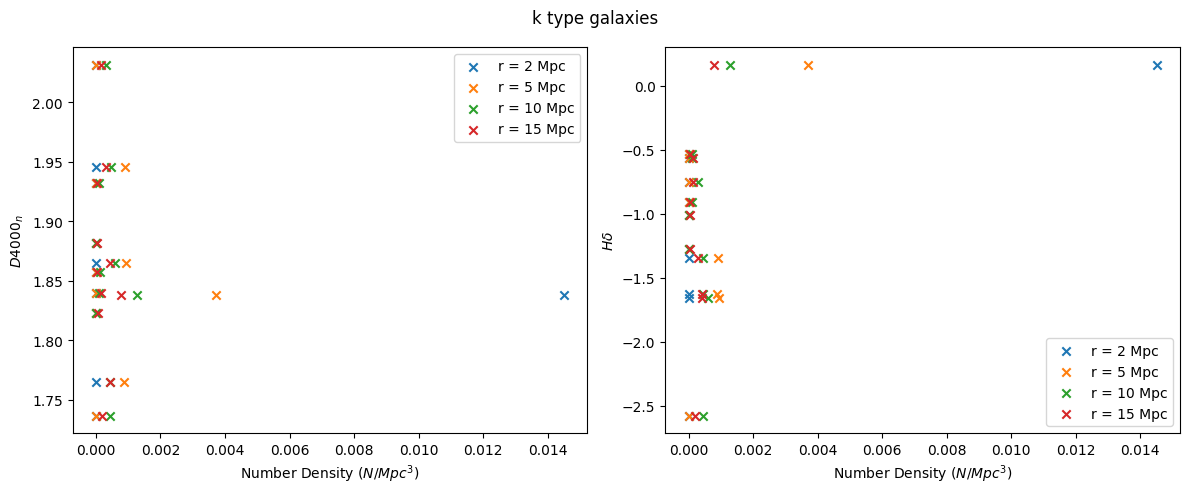

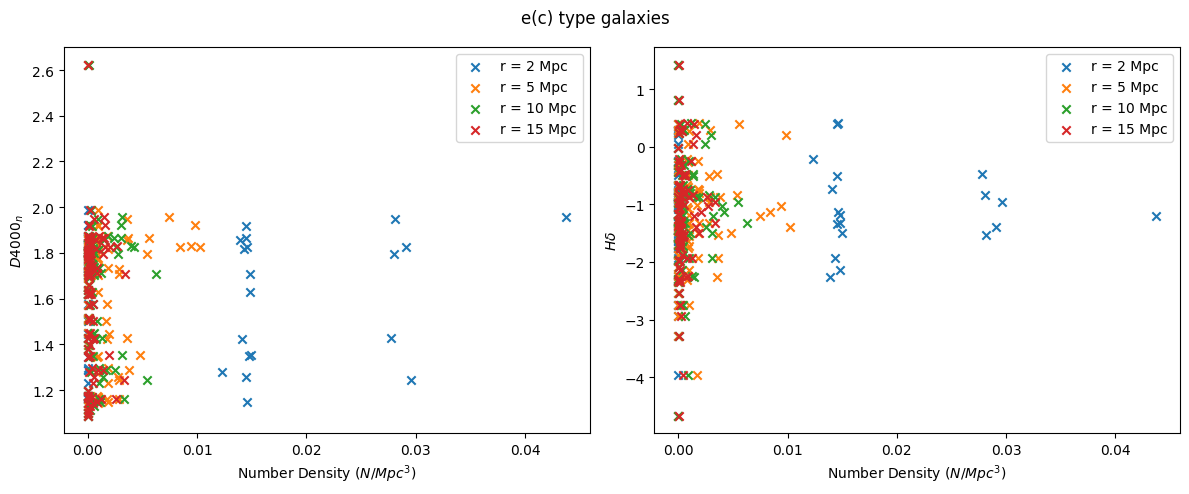

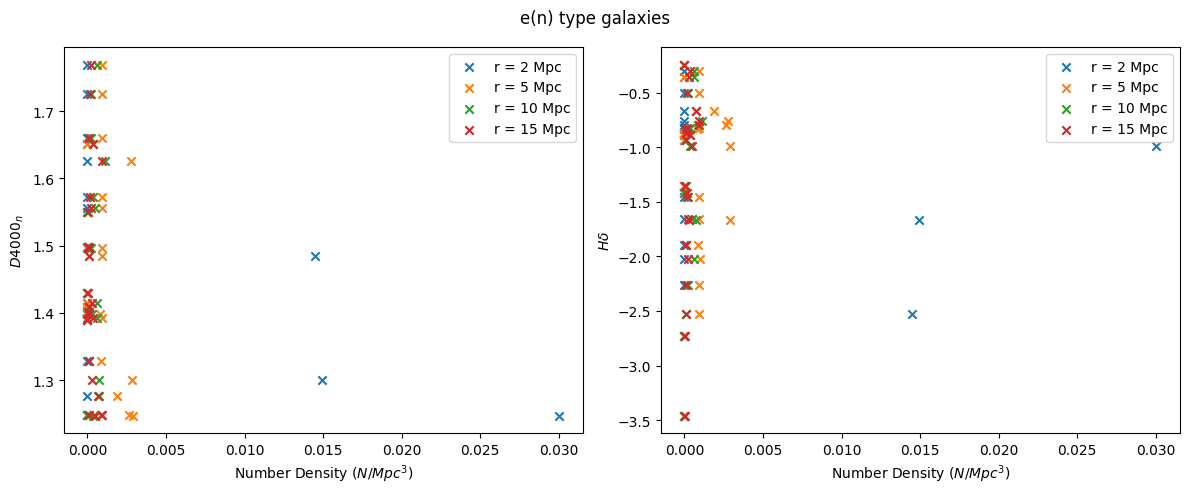

In [175]:
import matplotlib.pyplot as plt
import numpy as np

def plot_by_class_and_radius(result, radii=[2, 5, 10, 15]):
    """
    For each galaxy class, create two plots with an x-axis of the number density and a y-axis of either D4000n or Hdelta.
    Each search volume is represented as a different color
    """
    class_dict = result['class_dict']
    flat = {}
    for galaxy_class, data in class_dict.items():
        if '?' in galaxy_class:
            continue
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharex=True)
        for i, radius in enumerate(radii):
            # Flatten spectrum values into lists
            D4000n_vals  = []
            h_delta_vals = []
            oii_vals     = []
            dens_vals    = []
            for galaxy in data:
                dens_vals.append(galaxy['densities'][i])
                D4000n_vals.append(galaxy['D4000n'])
                h_delta_vals.append(galaxy['h_delta_EW'])
                oii_vals.append(galaxy['oii_EW'])
            
            dens_vals = np.array(dens_vals)
            D4000n_vals = np.array(D4000n_vals)

            # Create plots
            ax1.scatter(dens_vals, D4000n_vals, label=f'r = {radius} Mpc', marker='x')
            ax2.scatter(dens_vals, h_delta_vals, label=f'r = {radius} Mpc', marker='x')
        ax1.set_xlabel(r'Number Density ($N/Mpc^3$)')
        ax1.set_ylabel(r'$D4000_n$')
        ax1.legend()

        ax2.set_xlabel(r'Number Density ($N/Mpc^3$)')
        ax2.set_ylabel(r'$H\delta$')
        ax2.legend()
        fig.suptitle(f'{galaxy_class} type galaxies')
        fig.tight_layout() 
        plt.show()

plot_by_class_and_radius(result)
            

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def plot_all_classes(radius, result):
    # Extract flattened arrays per class
    flat = {}
    for galaxy_class, galaxies in result.items():
        # Flatten result into lists
        z_vals           = []
        D4000n_vals      = []
        n_neighbors_vals = []
        h_delta_vals     = []
        oii_vals         = []

        for g in galaxies:
            nnb = g.get('n_neighbors')
            # Skip galaxies without neighbor info
            if nnb is None:
                continue
            if radius not in nnb:
                return 'Radius chosen was not sampled. Choose from [2, 5, 10, 15]'
            
            z_vals.append(g['z'])
            D4000n_vals.append(g['D4000n'])
            n_neighbors_vals.append(g['n_neighbors'][radius])
            h_delta_vals.append(g['h_delta_EW'])
            oii_vals.append(g['oii_EW'])
        if len(z_vals) > 0 and '?' not in galaxy_class:
            flat[galaxy_class] = {
                'z': np.array(z_vals),
                'D4000n': np.array(D4000n_vals),
                'nnb': np.array(n_neighbors_vals),
                'h_delta': np.array(h_delta_vals),
                'oii': np.array(oii_vals)
            }
    # Plot 1: z vs D4000n (all classes)
    plt.figure(figsize=(7,5))
    for cls, data in flat.items():
        sizes = 5 + data['nnb']/2
        plt.scatter(data['z'], data['D4000n'], c=data['nnb'], s=sizes, alpha=0.5)
    plt.xlabel('z')
    plt.ylabel(r'$D4000_n$')
    plt.colorbar(label=f'num neighbors (R={radius} Mpc)')
    plt.title(r'All sampled galaxies: z vs $D4000_n$')
    plt.show()

    plt.figure(figsize=(7,5))
    for cls, data in flat.items():
        sizes = 5 + data['nnb']/2
        plt.scatter(data['z'], data['h_delta'], c=data['nnb'], s=sizes, alpha=0.5)
    plt.xlabel('z')
    plt.ylabel(r'H$\delta$')
    plt.colorbar(label=f'num neighbors (R={radius} Mpc)')
    plt.title(r'All sampled galaxies: z vs H$\delta$')
    plt.show()

    plt.figure(figsize=(7,5))
    for cls, data in flat.items():
        sizes = 5+data['nnb']/2
        plt.scatter(data['nnb'], data['D4000n'], c=data['z'], s=1.5, alpha=0.5)
    plt.xlabel(f'Num Neighbors (R={radius} Mpc)')
    plt.ylabel(r'$D4000_n$')
    plt.colorbar(label=f'Redshift (z)')
    plt.title(r'Num Neighbors vs $D4000_n$ (Colored by redshift)')
    plt.show()
            
plot_all_classes(15, result)

AttributeError: 'str' object has no attribute 'get'